<a href="https://colab.research.google.com/github/AndreHucke/gen_ai/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

Start by mounting the Google Drive directory. I decided to do this so I don't have to manually upload the waveform file every time I start a new runtime, which saves a lot of time. Then, I cd into the specific project directory and print the path to the screen just as a sanity check to ensure I am working in the correct location.

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/PhD/Generative_AI_for_Engineers/
! pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/PhD/Generative_AI_for_Engineers
/content/drive/MyDrive/PhD/Generative_AI_for_Engineers


---

Load the dataset and inspect its dimensions. I chose pandas to read the CSV since the data is tabular and it is the tool I am most comfortable with for this task. I then print the dataframe shape to verify the amount of samples and features (2000 samples and 130 columns, which includes the labels and label names in the last two positions). I also perform a sanity check on my dataframe, looking for any NA values to ensure the data is clean, and finally look at the head of the dataframe to confirm everything loaded correctly.

---

In [ ]:
import pandas as pd

df = pd.read_csv('waveforms_two_class.csv')
print(f'Samples by features: {df.shape}')
print(f'Column names: {df.columns}')
print(f'NA check: {df.isna().sum().sum()}')
print(f'\nHead')
df.head()

Samples by features: (2000, 130)
Column names: Index(['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       ...
       'x120', 'x121', 'x122', 'x123', 'x124', 'x125', 'x126', 'x127', 'label',
       'label_name'],
      dtype='object', length=130)
NA check: 0

Head


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x120,x121,x122,x123,x124,x125,x126,x127,label,label_name
0,-0.947141,-0.838508,-0.897306,-0.891606,-0.882936,-0.873445,-0.956327,-0.889972,-0.888553,-0.932892,...,-0.941790,-0.885358,-0.840000,-0.869320,-0.986899,-0.855718,-0.925747,-0.887413,1,square
1,0.786143,0.944359,0.909509,0.828856,0.768542,0.692954,0.534794,0.414327,0.190835,-0.153061,...,-0.754151,-0.762131,-0.936944,-0.922856,-0.808356,-0.725042,-0.625543,-0.509568,0,sine
2,-0.911261,0.920661,0.791735,0.892718,0.911063,0.878976,0.900652,0.877653,0.870198,0.870511,...,0.878529,0.870021,0.898435,-0.869937,-1.000000,-0.774808,-0.915988,-0.849216,1,square
3,-0.783615,-0.900473,-0.925583,-0.989462,-0.745357,-0.693783,-0.444357,-0.271567,0.040077,0.280479,...,-0.113384,0.166106,0.416596,0.653322,0.719588,0.920724,1.000000,0.989300,0,sine
4,0.851972,0.885557,0.913848,0.862640,0.888450,-0.884866,-0.975754,-0.863823,-0.944364,-0.844752,...,-0.910218,-0.956567,-1.000000,-0.894092,-0.883763,-0.930647,0.899971,0.941150,1,square


---

Let's play around with some plots using Seaborn. Since I am most familiar with Matplotlib, I wanted to try something new, though I realized it is built on top of Matplotlib, so I still need to use the underlying library. However, Seaborn is still cool for fast statistical visualization. I decided to randomly select a waveform from the dataset, dropping the label and label_name features to plot the raw signal as a line, and then adding the expected waveform type (from the label_name) to the title for verification.

---

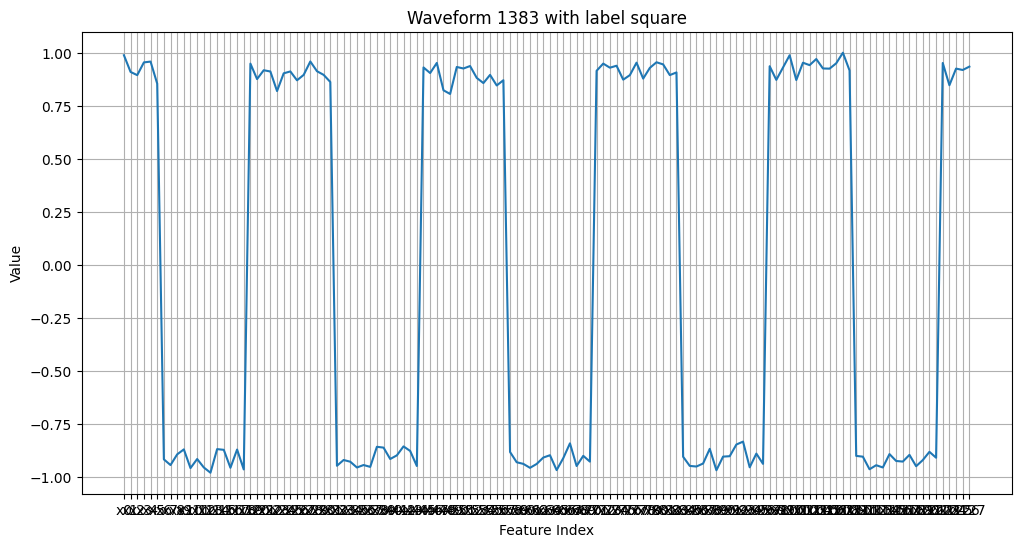

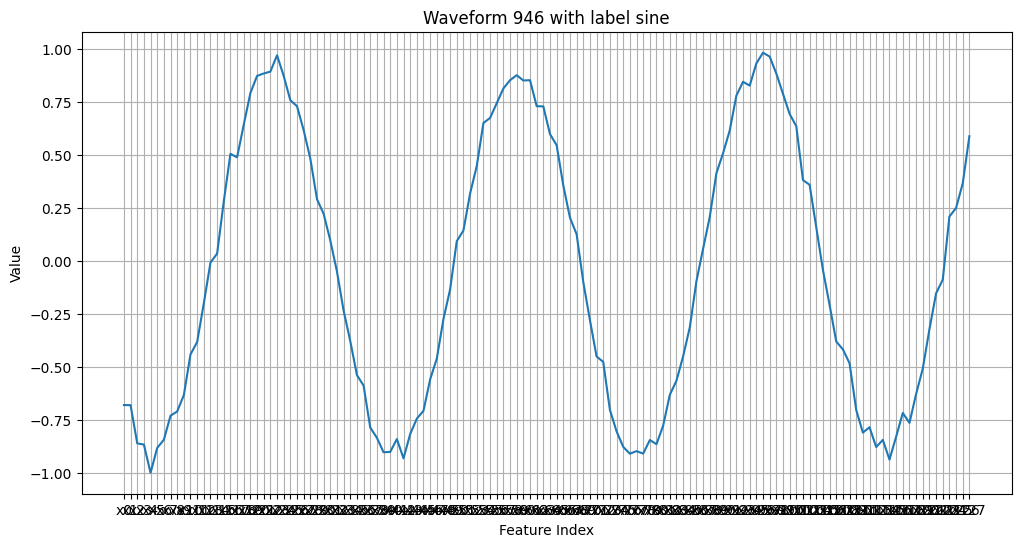

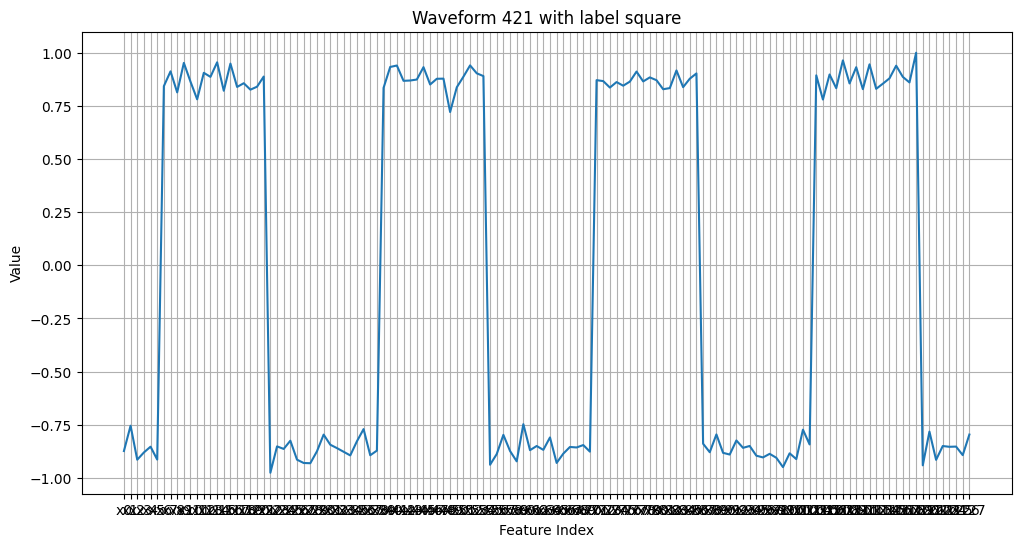

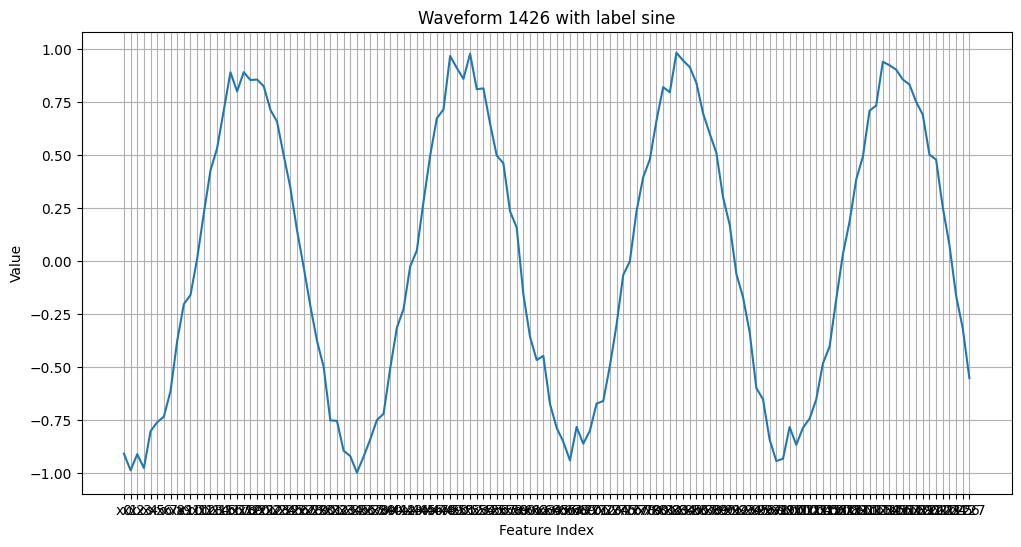

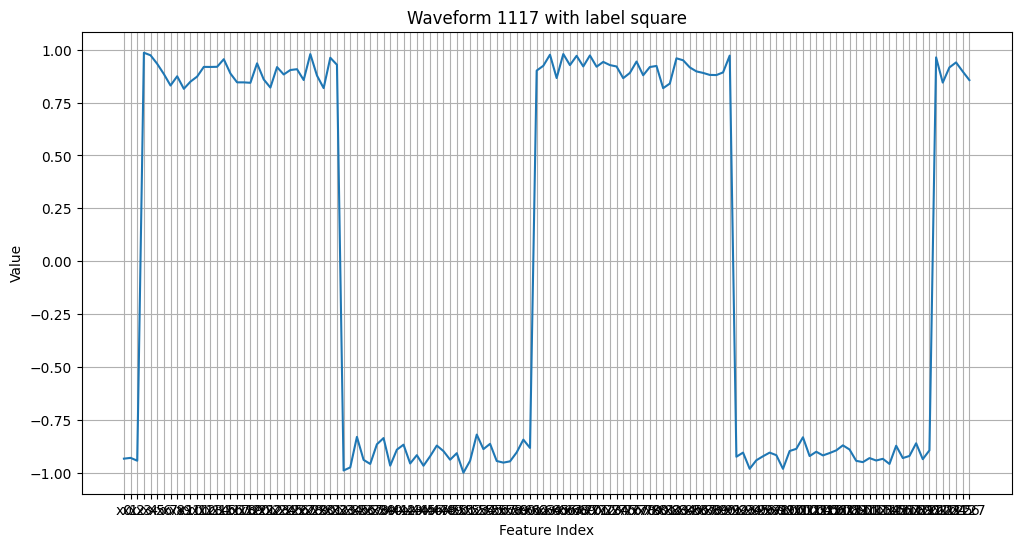

In [ ]:
from numpy.random import randint
import seaborn
import matplotlib.pyplot as plt

for i in range(5):
  n = randint(0, len(df))

  row_numeric = df.iloc[n].drop(['label', 'label_name'])

  label_str = df.iloc[n]['label_name']

  plt.figure(figsize=(12, 6))
  seaborn.lineplot(x=row_numeric.index, y=row_numeric.values)
  plt.title(f'Waveform {n} with label {label_str}')
  plt.xlabel('Feature Index')
  plt.ylabel('Value')
  plt.grid(True)
  plt.show()

---

Load the torch libraries for the model creation.

I create the train, val, and test splits with random splitting and class balance. I used the stratify parameter here because I don't want to train only on sine waves, for instance; I need the model to see a representative distribution of all waveforms.

I also decided to scale the data between -1 and 1 using MinMaxScaler. This choice was made to match the Tanh activation function I plan to use in the decoder's output. I fit the scaler only on the training set to prevent data leakage into the validation or test sets.

Finally, I wrap everything into DataLoaders to create the batches for each training step.

---

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Prepare Features and Labels
# We need 'y' (labels) specifically for the stratify parameter,
# even though the VAE only trains on 'X'.
X = df.drop(['label', 'label_name'], axis=1).values
y = df['label'].values

# First Split: Separate Train (80%) from Temp (20%)
# stratify=y ensures class balance is maintained in both sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Second Split: Separate Temp into Validation (10%) and Test (10%)
# We split the 20% chunk in half (0.5) to get two equal 10% chunks
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Initialize Scaler to fit between -1 and 1 (matching Tanh)
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit on Train ONLY to prevent data leakage, then transform all
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Re-create the TensorDatasets to include the labels (y_train, etc.)
# X_train is Float (continuous data), y_train is Long (integers for classes)
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))

# We don't strictly need val/test for the GAN loop, but good to have consistent
val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))
test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test))

# Re-initialize the DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Verification
print(f"Total samples: {len(df)}")
print(f"Train samples: {len(train_dataset)} ({len(train_dataset)/len(df):.0%})")
print(f"Val samples:   {len(val_dataset)} ({len(val_dataset)/len(df):.0%})")
print(f"Test samples:  {len(test_dataset)} ({len(test_dataset)/len(df):.0%})")

Total samples: 2000
Train samples: 1600 (80%)
Val samples:   200 (10%)
Test samples:  200 (10%)


---

Creating the VAE with torch. Since it is a VAE, I defined an encoder block to compress the data into a latent space and a decoder block that attempts to reconstruct the data based solely on that latent representation.

The reparameterize block is included to enable the "reparameterization trick" I learned about on Gemini, allowing gradients to flow back through the stochastic sampling step during training.

For my first pass, I decided to use a ReLU activation function, which in hindsight was not the best decision. Because I standardized the inputs to range from -1 to 1, a standard ReLU would zero out all the negative values, effectively discarding half the "shape" information of the waveforms. So, I decided to use Leaky ReLU in the forward block. This choice allows me to retain the benefits of ReLU while preserving the negative values that I considered important for this specific dataset.

---

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt

# Configuration
LATENT_DIM = 12  # Dimension of the noise vector 'z'
WAVEFORM_DIM = 128  # Your waveform size
NUM_CLASSES = 2 # Sine vs Square
HIDDEN_DIM = 200
LAMBDA_GP = 5   # Gradient penalty coefficient
BATCH_SIZE = 64
LR = 1e-4        # WGANs often prefer lower learning rates
BETA1 = 0.0      # WGAN-GP works best with Adam beta1 = 0
BETA2 = 0.9

class ConditionalGenerator(nn.Module):
    def __init__(self, latent_dim, num_classes, hidden_dim, output_dim):
        super(ConditionalGenerator, self).__init__()
        # Input dimension is Noise + One-Hot Label
        self.input_dim = latent_dim + num_classes

        self.net = nn.Sequential(
            nn.Linear(self.input_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 2, output_dim),
            nn.Tanh() # Output [-1, 1]
        )

    def forward(self, z, labels):
        # z: [batch, latent_dim]
        # labels: [batch, num_classes] (one-hot)
        x = torch.cat([z, labels], dim=1)
        return self.net(x)

class ConditionalCritic(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim):
        super(ConditionalCritic, self).__init__()
        # Input dimension is Waveform + One-Hot Label
        self.input_dim = input_dim + num_classes

        self.net = nn.Sequential(
            nn.Linear(self.input_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, 1) # Unbounded output
        )

    def forward(self, x, labels):
        # x: [batch, waveform_dim]
        # labels: [batch, num_classes] (one-hot)
        inputs = torch.cat([x, labels], dim=1)
        return self.net(inputs)

# Initialization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = ConditionalGenerator(LATENT_DIM, NUM_CLASSES, HIDDEN_DIM, WAVEFORM_DIM).to(device)
critic = ConditionalCritic(WAVEFORM_DIM, NUM_CLASSES, HIDDEN_DIM).to(device)

opt_gen = optim.Adam(generator.parameters(), lr=LR, betas=(BETA1, BETA2))
opt_critic = optim.Adam(critic.parameters(), lr=LR, betas=(BETA1, BETA2))

# Helper to one-hot encode integer labels
def to_onehot(labels, num_classes, device):
    batch_size = labels.size(0)
    one_hot = torch.zeros(batch_size, num_classes).to(device)
    one_hot.scatter_(1, labels.view(-1, 1), 1)
    return one_hot

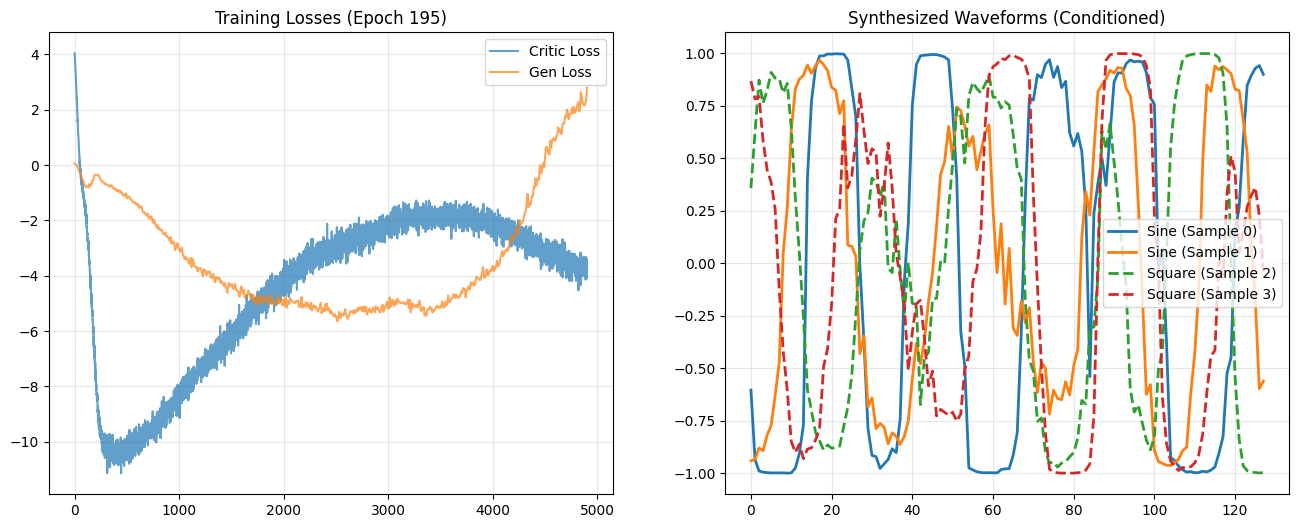

Training completed.


In [ ]:
from IPython.display import clear_output

def compute_gradient_penalty(critic, real_data, fake_data, labels, device):
    batch_size = real_data.size(0)
    alpha = torch.rand(batch_size, 1).to(device)

    # Interpolate between real and fake
    interpolates = (alpha * real_data + ((1 - alpha) * fake_data)).requires_grad_(True)

    # Critic score on interpolates (MUST PASS LABELS)
    d_interpolates = critic(interpolates, labels)

    fake = torch.ones(batch_size, 1).to(device)
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# Training Loop
n_epochs = 200
n_critic = 10
gen_losses = []
critic_losses = []

# Fixed noise/labels for consistent visualization over time
fixed_z = torch.randn(4, LATENT_DIM).to(device)
# Request: 2 Sines (Class 0), 2 Squares (Class 1)
fixed_labels_int = torch.tensor([0, 0, 1, 1]).to(device)
fixed_labels = to_onehot(fixed_labels_int, NUM_CLASSES, device)

for epoch in range(n_epochs):
    for i, (real_waveforms, labels_int) in enumerate(train_loader):

        real_waveforms = real_waveforms.to(device)
        labels = to_onehot(labels_int.to(device), NUM_CLASSES, device)
        batch_size = real_waveforms.size(0)

        # ---------------------
        #  Train Critic
        # ---------------------
        z = torch.randn(batch_size, LATENT_DIM).to(device)
        fake_waveforms = generator(z, labels) # Conditioned generation

        real_validity = critic(real_waveforms, labels)
        fake_validity = critic(fake_waveforms, labels)

        gp = compute_gradient_penalty(critic, real_waveforms, fake_waveforms, labels, device)

        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + LAMBDA_GP * gp

        opt_critic.zero_grad()
        d_loss.backward()
        opt_critic.step()
        critic_losses.append(d_loss.item())

        # ---------------------
        #  Train Generator
        # ---------------------
        if i % n_critic == 0:
            fake_waveforms = generator(z, labels)
            fake_validity = critic(fake_waveforms, labels)
            g_loss = -torch.mean(fake_validity)

            opt_gen.zero_grad()
            g_loss.backward()
            opt_gen.step()
            gen_losses.append(g_loss.item())

    # ---------------------
    #  Real-Time Visualization
    # ---------------------
    if epoch % 5 == 0: # Update every 5 epochs to reduce flicker
        clear_output(wait=True)

        generator.eval()
        with torch.no_grad():
            gen_waves = generator(fixed_z, fixed_labels).cpu().numpy()
        generator.train()

        # Create a 1x2 plot: Loss on left, Waveforms on right
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # Loss Plot
        axes[0].plot(critic_losses, label="Critic Loss", alpha=0.7)
        axes[0].plot(np.linspace(0, len(critic_losses), len(gen_losses)), gen_losses, label="Gen Loss", alpha=0.7)
        axes[0].set_title(f"Training Losses (Epoch {epoch})")
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Waveform Plot
        for idx, wave in enumerate(gen_waves):
            style = '--' if idx > 1 else '-' # Squares dashed, Sines solid
            lbl = "Sine" if idx < 2 else "Square"
            axes[1].plot(wave, linestyle=style, label=f"{lbl} (Sample {idx})", linewidth=2)

        axes[1].set_title("Synthesized Waveforms (Conditioned)")
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        axes[1].set_ylim(-1.1, 1.1)

        plt.show()

print("Training completed.")

---

Now, I am running the full model training using the winner. This is very similar to the trial runs, but with more epochs and patience for a longer training session. I also decided to train two additional models with 2x and 3x the latent dimension of the winner to answer the grad student question.

I also captured the loss history during this loop so I can plot the curves side-by-side later.

---

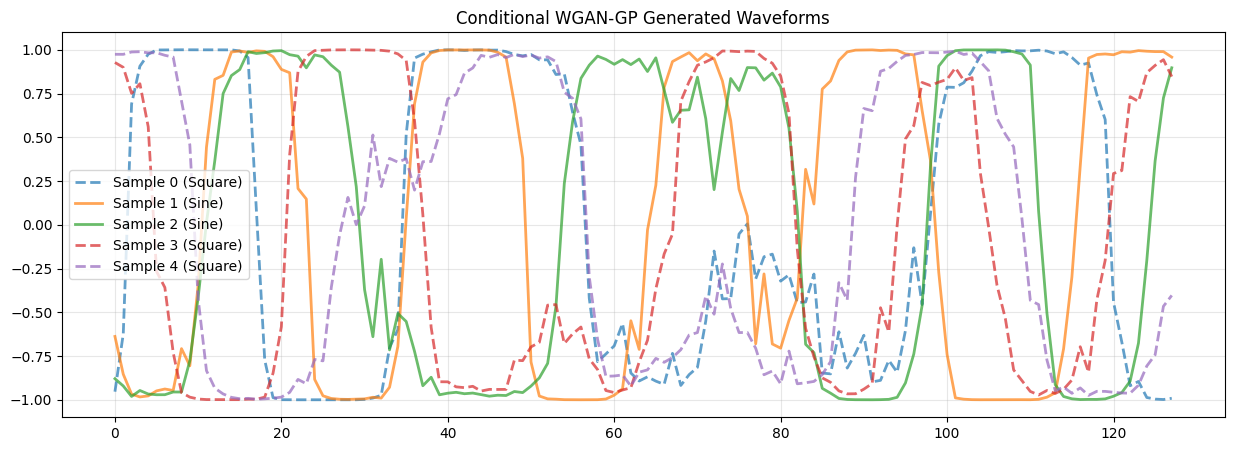

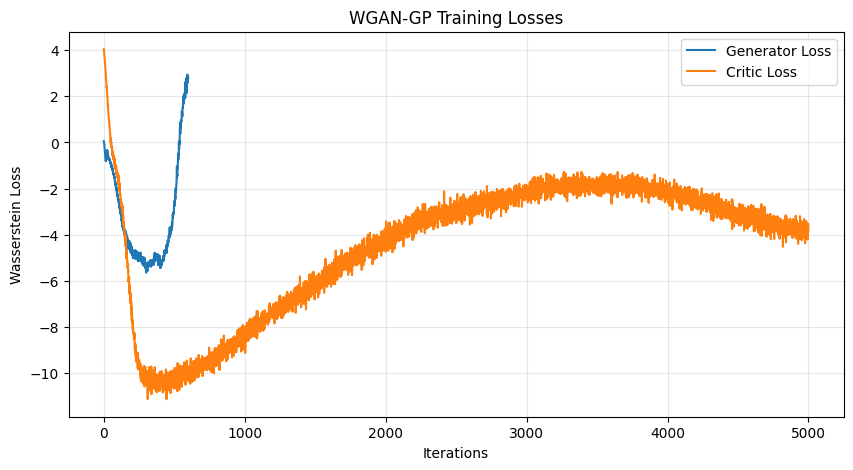

In [ ]:
# Visualize Results (Conditional)
generator.eval()

# 1. Generate new samples
with torch.no_grad():
    # Create noise
    z_sample = torch.randn(5, LATENT_DIM).to(device)

    # Create random labels for these 5 samples (integers 0 or 1)
    # This tells the generator WHICH shape to draw
    sample_labels_int = torch.randint(0, NUM_CLASSES, (5,)).to(device)
    sample_labels = to_onehot(sample_labels_int, NUM_CLASSES, device)

    # Pass both Noise AND Labels
    generated_waves = generator(z_sample, sample_labels).cpu().numpy()

# 2. Plot them
plt.figure(figsize=(15, 5))
colors = ['blue', 'orange'] # Color code by class

for i in range(5):
    label_idx = sample_labels_int[i].item()
    class_name = "Sine" if label_idx == 0 else "Square"

    plt.plot(generated_waves[i], alpha=0.7, linewidth=2,
             label=f'Sample {i} ({class_name})',
             linestyle='--' if label_idx == 1 else '-')

plt.title("Conditional WGAN-GP Generated Waveforms")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 3. Loss Curves (using the lists you populated during training)
plt.figure(figsize=(10, 5))
plt.plot(gen_losses, label="Generator Loss")
plt.plot(critic_losses, label="Critic Loss")
plt.title("WGAN-GP Training Losses")
plt.xlabel("Iterations")
plt.ylabel("Wasserstein Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Starting Unconditional Training...
Epoch 0 complete
Epoch 10 complete
Epoch 20 complete
Epoch 30 complete
Epoch 40 complete
Epoch 50 complete
Epoch 60 complete
Epoch 70 complete
Epoch 80 complete
Epoch 90 complete
Epoch 100 complete
Epoch 110 complete
Epoch 120 complete
Epoch 130 complete
Epoch 140 complete
Epoch 150 complete
Epoch 160 complete
Epoch 170 complete
Epoch 180 complete
Epoch 190 complete


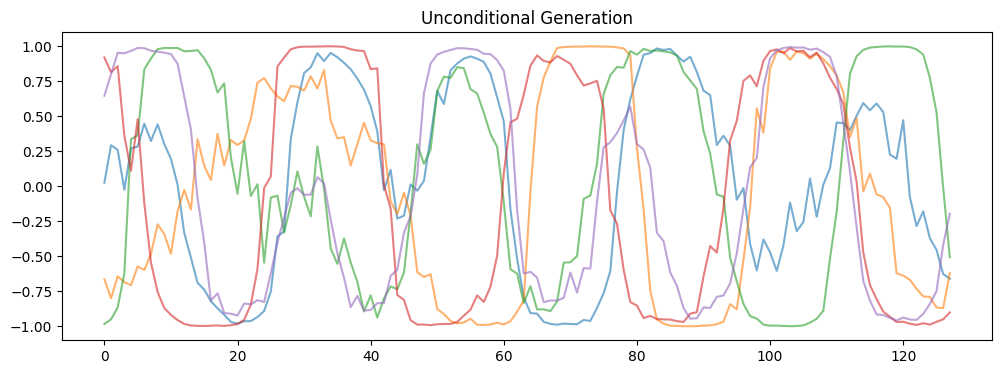

In [ ]:
# --- UNCONDITIONAL WGAN-GP (Grad Student Requirement) ---

# Redefine simple Generator/Critic without labels
class SimpleGenerator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(SimpleGenerator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 2, output_dim),
            nn.Tanh()
        )
    def forward(self, z):
        return self.net(z)

class SimpleCritic(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(SimpleCritic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(hidden_dim, 1)
        )
    def forward(self, x):
        return self.net(x)

# Re-init models
unc_generator = SimpleGenerator(LATENT_DIM, HIDDEN_DIM, WAVEFORM_DIM).to(device)
unc_critic = SimpleCritic(WAVEFORM_DIM, HIDDEN_DIM).to(device)
opt_gen_unc = optim.Adam(unc_generator.parameters(), lr=LR, betas=(BETA1, BETA2))
opt_critic_unc = optim.Adam(unc_critic.parameters(), lr=LR, betas=(BETA1, BETA2))

# Modified GP for Unconditional
def compute_gp_unc(critic, real, fake, device):
    alpha = torch.rand(real.size(0), 1).to(device)
    interpolates = (alpha * real + ((1 - alpha) * fake)).requires_grad_(True)
    d_interp = critic(interpolates)
    fake_grad = torch.ones(real.size(0), 1).to(device)
    grads = autograd.grad(d_interp, interpolates, fake_grad, create_graph=True, retain_graph=True)[0]
    return ((grads.view(grads.size(0), -1).norm(2, dim=1) - 1) ** 2).mean()

# Unconditional Loop
print("Starting Unconditional Training...")
for epoch in range(200): # 200 epochs for consistency
    for i, (real_waveforms, _) in enumerate(train_loader): # Ignore labels
        real_waveforms = real_waveforms.to(device)
        batch_size = real_waveforms.size(0)

        # Train Critic
        z = torch.randn(batch_size, LATENT_DIM).to(device)
        fake_waveforms = unc_generator(z)
        d_loss = -torch.mean(unc_critic(real_waveforms)) + torch.mean(unc_critic(fake_waveforms)) + \
                 LAMBDA_GP * compute_gp_unc(unc_critic, real_waveforms, fake_waveforms, device)

        opt_critic_unc.zero_grad(); d_loss.backward(); opt_critic_unc.step()

        # Train Generator
        if i % n_critic == 0:
            fake_waveforms = unc_generator(z)
            g_loss = -torch.mean(unc_critic(fake_waveforms))
            opt_gen_unc.zero_grad(); g_loss.backward(); opt_gen_unc.step()

    if epoch % 10 == 0: print(f"Epoch {epoch} complete")

# Visualize Unconditional
unc_generator.eval()
z_vis = torch.randn(5, LATENT_DIM).to(device)
unc_waves = unc_generator(z_vis).detach().cpu().numpy()
plt.figure(figsize=(12,4))
for w in unc_waves: plt.plot(w, alpha=0.6)
plt.title("Unconditional Generation"); plt.show()

---

Below is some code to print to pdf. I used this instead of the built-in solution because it was not printing plots.

---

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

In [ ]:
!jupyter nbconvert --to PDF "gan.ipynb"